In [68]:
from natsort import natsorted
import os
import re
from glob import glob
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import networkx as nx


import imageio
import cv2
import skimage
from skimage import img_as_float32, img_as_ubyte, img_as_uint
from skimage.feature import canny
from skimage.color import rgb2gray, rgb2hsv, gray2rgb, rgba2rgb
from sklearn.model_selection import train_test_split
from functools import partial
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16

# caching with sane defaults
from cachier import cachier

In [69]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [70]:
tqdm = partial(tqdm, position=0, leave=True)


cachier = partial(cachier, pickle_reload=False, cache_dir="data/cache")

### Read and Scale data

In [71]:
############################## Stuff for loading and rescaling the puzzle pieces nicely ################################
SIZE = (768, 1024)

DATA_PATH_PAIRS = list(
    zip(
        natsorted(
            glob(
                f"puzzle_corners_{SIZE[1]}x{SIZE[0]}/images-{SIZE[1]}x{SIZE[0]}/*.png"
            )
        ),
        natsorted(
            glob(
                f"puzzle_corners_{SIZE[1]}x{SIZE[0]}/masks-{SIZE[1]}x{SIZE[0]}/*.png"
            )
        ),
    )
)
DATA_IMGS = np.array(
    [
        img_as_float32(imageio.imread(img_path))
        for img_path, _ in tqdm(DATA_PATH_PAIRS, "Loading Images")
    ]
)
DATA_MSKS = np.array(
    [
        img_as_float32(imageio.imread(msk_path))
        for _, msk_path in tqdm(DATA_PATH_PAIRS, "Loading Masks")
    ]
)

SCALE = 0.25
MATCH_IMGS = np.array([
    cv2.resize(img, None, fx=SCALE, fy=SCALE)
    for img in tqdm(DATA_IMGS, "Resizing Images")
])
MATCH_MSKS = np.array([
    np.expand_dims(cv2.resize(img, None, fx=SCALE, fy=SCALE), axis=2)
    for img in tqdm(DATA_MSKS, "Resizing Masks")
])

Loading Images:   0%|          | 0/48 [00:00<?, ?it/s]

Loading Masks:   0%|          | 0/48 [00:00<?, ?it/s]

Resizing Images:   0%|          | 0/48 [00:00<?, ?it/s]

Resizing Masks:   0%|          | 0/48 [00:00<?, ?it/s]

In [72]:
def plot_img(img):
    plt.imshow(img, cmap='gray')
    plt.show

In [6]:
# np.squeeze(MATCH_MSKS).shape

(48, 192, 256)

In [7]:
# np.squeeze(tf.image.flip_left_right(MATCH_MSKS[0]).numpy()).shape

(192, 256)

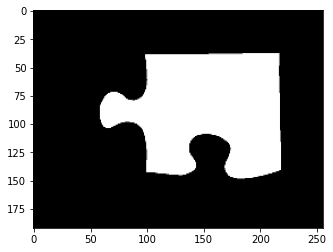

In [8]:
# plot_img(tf.image.flip_left_right(MATCH_MSKS[0]).numpy())

# Data augmentations

In [73]:
def train_val_test_split(X, y, train_count=34, val_count=7, test_count=7, random_state=42):
    """ Split data into train, validation and test sets"""
    # Obtain percentage split values
    total_data_size = X.shape[0]
    train_size = train_count / total_data_size
    val_size = val_count / total_data_size
    test_size = val_count / total_data_size
   
    X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=train_size, random_state=random_state)
    val_size = val_size/(val_size+test_size)
    X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, train_size=val_size, random_state=random_state)
    
    print(f"Training images: {X_train.shape[0]}")
    print(f"Validation images: {X_val.shape[0]}")
    print(f"Test images: {X_test.shape[0]}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [74]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(MATCH_IMGS, MATCH_MSKS)

Training images: 34
Validation images: 7
Test images: 7


In [21]:
# temp = tf.image.flip_left_right(MATCH_MSKS)

In [28]:
# np.squeeze(temp.numpy()).shape

(48, 192, 256)

In [32]:
# y_train.concat(np.squeeze(temp.numpy())).shape

AttributeError: 'numpy.ndarray' object has no attribute 'concat'

In [35]:
# np.append(y_train, np.squeeze(temp.numpy()), 0).shape

(82, 192, 256)

In [75]:
def apply_image_aug(aug_func, X_train, X_val, y_train, y_val):
    
    X_train = np.append(X_train, aug_func(X_train[:34]).numpy(), 0)
    y_train = np.append(y_train, aug_func(y_train[:34]).numpy(), 0)
    
    X_val = np.append(X_val, aug_func(X_val[:7]).numpy(), 0)
    y_val = np.append(y_val, aug_func(y_val[:7]).numpy(), 0)
    
    return X_train, X_val, y_train, y_val
    

In [76]:
def add_data_augmentations(X_train, X_val, y_train, y_val):
    # Spatial augmentations
    
    ## Flipping
    
    X_train, X_val, y_train, y_val = apply_image_aug(tf.image.flip_left_right, X_train, X_val, y_train, y_val)
    # X_train, X_val, y_train, y_val = apply_image_aug(tf.image.flip_right_left, X_train, X_val, y_train, y_val)
    
    
    ## Rotation
    
    # Pixel augmentations
    
    ## Brightness
    
    ## Contrast
    
    ## Saturation
    
    ## Hue
    
    
    return X_train, X_val, y_train, y_val

In [77]:
print(f"Training images: {X_train.shape[0]}")
print(f"Validation images: {X_val.shape[0]}")
print(f"Test images: {X_test.shape[0]}")


Training images: 34
Validation images: 7
Test images: 7


In [78]:
X_train, X_val, y_train, y_val = add_data_augmentations(X_train, X_val, y_train, y_val)

In [79]:
print(f"Training images: {X_train.shape[0]}")
print(f"Validation images: {X_val.shape[0]}")
print(f"Test images: {X_test.shape[0]}")


Training images: 68
Validation images: 14
Test images: 7


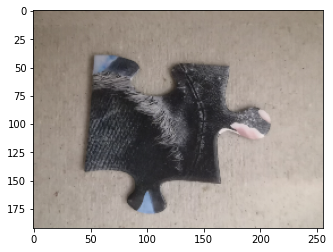

In [85]:
plot_img(X_train[0])

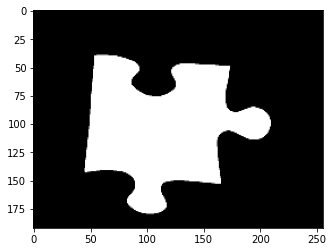

In [83]:
plot_img(y_train[0])

In [12]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

In [13]:
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [14]:
def build_vgg16_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained VGG16 Model """
    vgg16 = VGG16(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = vgg16.get_layer("block1_conv2").output         ## (512 x 512)
    s2 = vgg16.get_layer("block2_conv2").output         ## (256 x 256)
    s3 = vgg16.get_layer("block3_conv3").output         ## (128 x 128)
    s4 = vgg16.get_layer("block4_conv3").output         ## (64 x 64)

    """ Bridge """
    b1 = vgg16.get_layer("block5_conv3").output         ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)

    """ Output """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="VGG16_U-Net")
    return model


In [15]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [16]:
input_shape = X_train[0].shape
model = build_vgg16_unet(input_shape)

In [17]:
model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
y_train = np.squeeze(y_train)
y_test = np.squeeze(y_test)

In [19]:
history = model.fit(X_train, y_train, 
                    batch_size=2, 
                    verbose=1, 
                    epochs=100, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

Epoch 1/100
17/17 [==============================] - 5s 86ms/step - loss: 0.2029 - accuracy: 0.9322 - val_loss: 11.3238 - val_accuracy: 0.2552
Epoch 2/100
17/17 [==============================] - 1s 43ms/step - loss: 0.0757 - accuracy: 0.9799 - val_loss: 11.2294 - val_accuracy: 0.2552
Epoch 3/100
17/17 [==============================] - 1s 44ms/step - loss: 0.0494 - accuracy: 0.9860 - val_loss: 10.4306 - val_accuracy: 0.2553
Epoch 4/100
13/17 [=====================>........] - ETA: 0s - loss: 0.0381 - accuracy: 0.9880

KeyboardInterrupt: 

In [ ]:
# model.save('test.hdf5')

In [ ]:
from keras.models import load_model
model = load_model("test.hdf5", compile=False)

In [21]:
test_img_input=np.expand_dims(X_test[0], 0)

In [22]:
test_img_input.shape

(1, 192, 256, 3)

In [23]:
ans = model.predict(test_img_input)

In [24]:
img = (ans[0,:,:,0] > 0.5).astype(np.uint8)

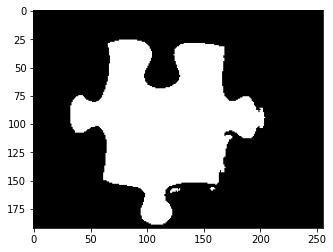

In [25]:
plt.imshow(img, cmap='gray')
plt.show()